In [2]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
os.environ["KERAS_BACKEND"] = "torch"
import keras
from datamodules import data_processors
from sklearn.preprocessing import StandardScaler
import sys
print(sys.version)

3.13.1 (main, Dec  9 2024, 00:00:00) [GCC 14.2.1 20240912 (Red Hat 14.2.1-3)]


In [29]:
N_archivos = 17
key_features = "x_"
path_rand = map(lambda x: "../input_data/cubic_" + str(x + 1) + ".csv", range(N_archivos))
datos_rand = [pd.read_csv(x) for x in path_rand]
path_to_current_model = "models/cubico_L4.keras" #"models/isotropico_act_custom_6.keras" # colocar "none" si quiere entrenar un modelo

In [30]:
datos_rand[0].head()

,phi_a,x_K,eta,beta,phi_K,eig_0,eig_1,eig_2,eig_3,eig_4,...,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,Parallelepiped,Cylinder,Ellipsoid
0,0.843666,0.647473,1.577259,1.574131,0.866533,0.552390,2.341186,2.982731,4.346947,4.543615,...,10.255629,10.934964,12.169362,12.639375,13.023291,17.260278,18.912029,1,0,0
1,0.618911,0.218057,1.216162,1.820191,1.350973,0.451902,1.069440,2.198825,3.912317,3.934114,...,11.230938,11.241764,11.468446,14.561622,14.919805,15.338283,15.666733,1,0,0
2,0.076877,0.245986,1.434582,2.036289,1.322259,0.104398,3.832743,4.758215,5.732612,5.807000,...,15.088024,15.429422,16.241738,16.394792,20.165109,25.500514,26.305482,1,0,0
3,1.459619,0.517388,1.481719,1.376496,1.027000,0.202136,2.142934,2.641222,2.779140,3.088002,...,10.969815,12.756643,13.922951,14.045571,15.047647,18.770442,19.392401,1,0,0
4,0.032508,0.949501,1.839938,0.803203,0.319154,0.002714,10.061990,13.963490,14.997477,17.405756,...,56.063736,70.470168,72.668095,76.780522,93.416045,97.561829,106.012724,1,0,0


In [31]:
N_eig = 19
features = ["eta", "beta"] + list(map(lambda x: key_features + str(x), range(N_eig + 1)))
target = ["phi_a", "phi_K"]

In [32]:
datos_post = []
for datos in datos_rand:
    datos_post.append(data_processors.preprocess_data(datos, N_eig, target))
#fin for 
datos_rand = datos_post

In [33]:
datos_rand[0].head()

,phi_a,phi_K,eig_0,eta,beta,eig_1,eig_2,eig_3,eig_4,eig_5,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0.537095,0.551652,0.552390,1.577259,1.574131,0.427134,0.784913,0.686167,0.956716,0.970898,...,0.044254,0.003605,0.062714,0.011232,0.035921,0.065271,0.024853,0.020300,0.224037,0.087339
1,0.394011,0.860056,0.451902,1.216162,1.820191,0.935069,0.486369,0.562026,0.994460,0.833391,...,0.036307,0.021216,0.141992,0.012995,0.000691,0.014469,0.197436,0.022863,0.026711,0.020965
2,0.048942,0.841777,0.104398,1.434582,2.036289,0.260910,0.805500,0.830026,0.987190,0.736554,...,0.024378,0.078955,0.079060,0.006715,0.012978,0.030880,0.005818,0.143328,0.202825,0.030601
3,0.929222,0.653809,0.202136,1.481719,1.376496,0.466650,0.811342,0.950374,0.899980,0.743699,...,0.023561,0.006362,0.055864,0.047249,0.092141,0.060143,0.006323,0.051674,0.191972,0.032072
4,0.020696,0.203180,0.002714,1.839938,0.803203,0.099384,0.720593,0.931056,0.861639,0.698142,...,0.060522,0.001708,0.122370,0.014358,0.135893,0.020733,0.038792,0.156920,0.039106,0.079716


In [34]:
datos_rand[0].keys()

Index(['phi_a', 'phi_K', 'eig_0', 'eta', 'beta', 'eig_1', 'eig_2', 'eig_3',
       'eig_4', 'eig_5', 'eig_6', 'eig_7', 'eig_8', 'eig_9', 'eig_10',
       'eig_11', 'eig_12', 'eig_13', 'eig_14', 'eig_15', 'eig_16', 'eig_17',
       'eig_18', 'eig_19', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6',
       'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15',
       'x_16', 'x_17', 'x_18', 'x_19'],
      dtype='object')

In [35]:
X_rand = [datos_rand[x][features] for x in range(N_archivos)]
y_rand = [datos_rand[x][target] for x in range(N_archivos)]

In [36]:
N_train = 13
X_train = pd.concat((X_rand[i] for i in range(N_train)), axis = 0)
y_train = pd.concat((y_rand[i] for i in range(N_train)), axis = 0)

In [37]:
X_train.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,1.577259,1.574131,0.052876,0.070917,0.033923,0.072135,0.010399,0.007201,0.014744,0.043735,...,0.044254,0.003605,0.062714,0.011232,0.035921,0.065271,0.024853,0.020300,0.224037,0.087339
1,1.216162,1.820191,0.063830,0.004432,0.072088,0.109371,0.001391,0.050202,0.004016,0.031852,...,0.036307,0.021216,0.141992,0.012995,0.000691,0.014469,0.197436,0.022863,0.026711,0.020965
2,1.434582,2.036289,0.038015,0.107686,0.035182,0.037042,0.002828,0.078957,0.007227,0.043786,...,0.024378,0.078955,0.079060,0.006715,0.012978,0.030880,0.005818,0.143328,0.202825,0.030601
3,1.481719,1.376496,0.051567,0.058937,0.025695,0.007112,0.015927,0.054878,0.011324,0.097216,...,0.023561,0.006362,0.055864,0.047249,0.092141,0.060143,0.006323,0.051674,0.191972,0.032072
4,1.839938,0.803203,0.009433,0.085480,0.036802,0.009753,0.022717,0.070989,0.010528,0.033579,...,0.060522,0.001708,0.122370,0.014358,0.135893,0.020733,0.038792,0.156920,0.039106,0.079716


In [38]:
estadisticas = pd.DataFrame(X_train.describe())
estadisticas.to_csv("models/cubico_L4_stats.csv")

In [39]:
X_train.describe()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
count,649900.000000,649900.000000,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,...,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05,6.499000e+05
mean,1.187440,1.573669,4.186485e-02,3.349854e-02,3.061555e-02,3.654942e-02,2.762993e-02,3.215918e-02,3.516314e-02,4.684079e-02,...,5.107271e-02,6.068709e-02,5.630382e-02,5.474588e-02,6.291968e-02,5.757489e-02,6.295832e-02,6.598725e-02,7.647416e-02,8.633633e-02
std,0.460811,0.906339,5.279436e-02,4.034393e-02,2.869737e-02,3.792186e-02,3.115177e-02,3.198855e-02,3.465372e-02,4.964440e-02,...,5.261793e-02,5.910831e-02,5.516498e-02,5.230132e-02,6.015050e-02,5.571085e-02,6.386611e-02,6.685615e-02,7.466148e-02,9.933991e-02
min,0.004468,0.000209,3.326231e-10,3.438947e-11,1.180504e-08,2.582404e-08,1.207940e-09,1.272049e-07,7.141159e-08,4.997769e-10,...,1.915992e-07,3.084634e-08,1.338702e-07,2.252204e-07,7.247275e-09,2.222201e-07,2.017425e-07,3.492429e-08,3.446170e-07,1.260690e-07
25%,0.842277,0.790523,5.296625e-03,4.376420e-03,7.336578e-03,7.927401e-03,6.653845e-03,8.722573e-03,1.008609e-02,1.143280e-02,...,1.397784e-02,1.688292e-02,1.624622e-02,1.592446e-02,1.771337e-02,1.623921e-02,1.733723e-02,1.856828e-02,2.156522e-02,2.245085e-02
50%,1.233274,1.575621,2.242351e-02,1.630897e-02,2.183716e-02,2.356897e-02,1.817730e-02,2.185416e-02,2.487203e-02,3.096812e-02,...,3.380619e-02,4.217783e-02,3.937678e-02,3.903285e-02,4.408998e-02,4.034575e-02,4.207505e-02,4.534988e-02,5.260023e-02,5.638384e-02
75%,1.574521,2.357825,5.860687e-02,4.713692e-02,4.687325e-02,5.318703e-02,3.821207e-02,4.532048e-02,4.956574e-02,6.653462e-02,...,6.952791e-02,8.642436e-02,7.888707e-02,7.780245e-02,9.061016e-02,8.191918e-02,8.737453e-02,9.179261e-02,1.077536e-01,1.147540e-01
max,1.916369,3.141587,5.471063e-01,2.007268e-01,2.765136e-01,3.236721e-01,3.449917e-01,2.847936e-01,4.019465e-01,4.261220e-01,...,4.484724e-01,5.025386e-01,5.467410e-01,6.136433e-01,5.436618e-01,5.154888e-01,7.284368e-01,6.888602e-01,8.206148e-01,7.727486e-01


In [40]:
X_train = data_processors.scale(X_train)
X_train.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0.845943,0.000510,0.208574,0.927489,0.115239,0.938389,-0.553126,-0.780210,-0.589236,-0.062567,...,-0.129589,-0.965728,0.116195,-0.831986,-0.448856,0.138135,-0.596651,-0.683365,1.976421,0.010090
1,0.062329,0.271998,0.416042,-0.720462,1.445170,1.920319,-0.842285,0.564031,-0.898809,-0.301917,...,-0.280613,-0.667778,1.553310,-0.798283,-1.034550,-0.773743,2.105619,-0.645036,-0.666514,-0.658060
2,0.536322,0.510428,-0.072924,1.838887,0.159115,0.012978,-0.796169,1.462967,-0.806163,-0.061531,...,-0.507323,0.309056,0.412504,-0.918354,-0.830276,-0.479167,-0.894685,1.156827,1.692315,-0.561060
3,0.638613,-0.217549,0.183765,0.630545,-0.171463,-0.776266,-0.375677,0.710219,-0.687917,1.014720,...,-0.522850,-0.919075,-0.007964,-0.143343,0.485797,0.046089,-0.886781,-0.214096,1.546952,-0.546246
4,1.415981,-0.850086,-0.614309,1.288464,0.215582,-0.706612,-0.157713,1.213876,-0.710892,-0.267129,...,0.179577,-0.997814,1.197615,-0.772212,1.213187,-0.661312,-0.378394,1.360127,-0.500495,-0.066645


In [41]:
corr_mat = X_train.select_dtypes(include=['number']).corr()
print(corr_mat)

           eta      beta       x_0       x_1       x_2       x_3       x_4  \
eta   1.000000 -0.001376  0.524245  0.491435  0.393385  0.197263  0.133262   
beta -0.001376  1.000000  0.576603  0.326650  0.162856  0.404220  0.350455   
x_0   0.524245  0.576603  1.000000  0.379525  0.315854  0.357219  0.359167   
x_1   0.491435  0.326650  0.379525  1.000000  0.180475  0.056126  0.053953   
x_2   0.393385  0.162856  0.315854  0.180475  1.000000  0.032097  0.158813   
x_3   0.197263  0.404220  0.357219  0.056126  0.032097  1.000000  0.159266   
x_4   0.133262  0.350455  0.359167  0.053953  0.158813  0.159266  1.000000   
x_5   0.220397  0.011640  0.064195  0.168107  0.164430 -0.041320 -0.100046   
x_6   0.032117  0.250571  0.073478  0.054307  0.114170  0.056778  0.175421   
x_7  -0.000293  0.312379  0.128924  0.063006 -0.003972  0.373983  0.106954   
x_8   0.077446  0.129090  0.103211  0.215604  0.040578  0.079732  0.073402   
x_9  -0.119911  0.021856 -0.065840 -0.042481  0.069892 -0.039805

Text(0.5, 1.0, 'Correlation Matrix')

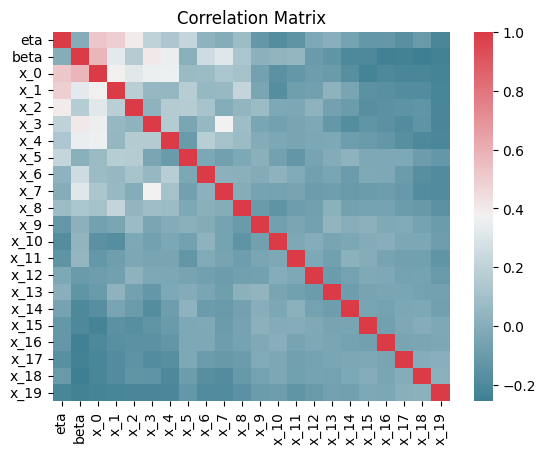

In [42]:
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

In [43]:
torch.cuda.get_device_properties(torch.device("cuda"))

_CudaDeviceProperties(name='AMD Radeon RX 6600M', major=10, minor=3, gcnArchName='gfx1030', total_memory=8176MB, multi_processor_count=14, uuid=58580000-0000-0000-0000-000000000000, L2_cache_size=2MB)

In [44]:
def crear_modelo_de_regresion(lr_var, n_input_data, def_act = 'relu'):    
    modelo = keras.models.Sequential()
    modelo.add(keras.layers.Dense(256, activation = def_act, input_shape = (n_input_data,)))
    modelo.add(keras.layers.Dense(1024, activation = def_act))
    modelo.add(keras.layers.Dense(1400, activation = def_act))
    modelo.add(keras.layers.Dense(2490, activation = def_act))
    modelo.add(keras.layers.Dense(6333, activation = def_act))
    modelo.add(keras.layers.Dense(6295, activation = def_act))
    modelo.add(keras.layers.Dense(2566, activation = def_act))
    modelo.add(keras.layers.Dense(2004, activation = def_act))
    modelo.add(keras.layers.Dense(1086, activation = def_act))
    modelo.add(keras.layers.Dense(700, activation = def_act))
    modelo.add(keras.layers.Dense(384, activation = def_act))
    modelo.add(keras.layers.Dense(64, activation = def_act))
    modelo.add(keras.layers.Dense(2, activation = 'hard_sigmoid'))
    modelo.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_var), loss = 'mse', metrics = ['mae']) #RMSprop
    return modelo

In [45]:
X_val = pd.concat((X_rand[i] for i in range(N_train, N_train + 2)), axis = 0)
y_val = pd.concat((y_rand[i] for i in range(N_train, N_train + 2)), axis = 0)
X_test = pd.concat((X_rand[i] for i in range(N_train + 2, N_archivos)), axis = 0)
y_test = pd.concat((y_rand[i] for i in range(N_train + 2, N_archivos)), axis = 0)
X_val = data_processors.scale(X_val)
X_test = data_processors.scale(X_test)

In [46]:
X_val.head()

,eta,beta,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
0,0.968417,-1.478413,-0.669048,-0.781706,-0.847847,-0.353583,-0.811000,0.302204,-0.385486,-0.388588,...,1.759124,0.594402,0.180208,-0.179927,-0.253459,-0.338761,-0.798260,-0.212405,-0.615334,2.089396
1,-0.801850,1.213975,-0.484482,-0.670495,0.391983,0.252607,-0.105467,1.916435,2.173715,0.202740,...,-0.728374,-0.159967,-0.779133,-0.221164,-0.962123,1.886153,-0.167518,-0.102349,-0.199411,0.302543
2,-0.510112,0.034424,-0.293621,-0.795896,0.697285,-0.000030,0.238053,0.635415,-0.974489,0.688456,...,-0.076293,-0.982487,-0.610709,0.483110,0.329850,-0.011723,-0.865604,1.679554,-0.195344,-0.176743
3,-1.432979,-1.412603,-0.787296,-0.745102,-0.942971,-0.730456,-0.379416,-0.120721,-0.483145,-0.569540,...,-0.780471,-0.473994,-0.125613,-0.214614,3.529453,-0.175103,0.414196,-0.839004,0.385380,0.321380
4,1.466530,-0.425311,-0.037946,0.800435,2.341428,-0.562248,-0.381192,-0.731262,0.768444,1.776709,...,-0.070368,-0.464818,0.501141,-0.242831,-0.401078,0.482605,-0.762352,-0.368921,-0.747514,0.336297


In [47]:
epocas = 100
nombre_modelo = "cubico_L4.keras"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "models/" + nombre_modelo,  
    save_best_only=True,
    save_weights_only=False, 
)

In [48]:
if path_to_current_model == "none":
    path_model = "models/" + nombre_modelo
    try:
        modelo = keras.models.load_model(path_model)
    except: 
        modelo = crear_modelo_de_regresion(0.0005, len(features))
    #fin exception
    history = modelo.fit(X_train, y_train, epochs = epocas, batch_size=160, 
                            validation_data = (X_val, y_val), callbacks=[checkpoint_callback])
else:
    modelo = keras.models.load_model(path_to_current_model)
#fin if 

In [49]:
mets_train = data_processors.get_metrics(X_train, y_train, modelo)
mets_val = data_processors.get_metrics(X_val, y_val, modelo)
mets_rand1 = data_processors.get_metrics(X_test, y_test, modelo)

20310/20310 ━━━━━━━━━━━━━━━━━━━━ 184s 9ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step


In [50]:
print("Train: ", mets_train)
print("Val: ", mets_val)
print("Test: ", mets_rand1)

Train:  {'R2': 0.9712870717048645, 'RMSE': 0.03740731254220009, 'MAE': 0.0190086979418993, 'SDAE': np.float64(0.23042090776828006)}
Val:  {'R2': 0.9284567832946777, 'RMSE': 0.05924077332019806, 'MAE': 0.027720453217625618, 'SDAE': np.float64(0.23054906640719305)}
Test:  {'R2': 0.926748514175415, 'RMSE': 0.060274653136730194, 'MAE': 0.027923960238695145, 'SDAE': np.float64(0.23031785031170598)}


In [26]:
if path_to_current_model == "none":
    modelo.save("models/" + nombre_modelo)
    #modelo.save("models/cubico_L4_final.keras")
#fin if 

In [27]:
if path_to_current_model == "none":
    train_mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    plt.figure()
    plt.plot(train_mae, label='Train MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE over Epochs')
    plt.legend()

In [28]:
if path_to_current_model == "none":
    import json
    with open('models/' + nombre_modelo[:-6] +'_history.json', 'w') as f:
        json.dump(history.history, f)